In [1]:
!pip install opencv-python
!pip install scikit-image

In [2]:
!cat $PWD

cat: /opt/workspace/notebooks: Is a directory


In [3]:
%matplotlib inline  
import timeit
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from PIL import Image
import os
from tensorflow.keras import layers, models

from skimage import io

faces_path = '/opt/workspace/data/face/'
no_faces_path = '/opt/workspace/data/noface/'

In [4]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = io.imread(os.path.join(folder,filename))
        if img.shape[0]==198 and img.shape[1]==198:
            images.append(img)
    return images

images_with_face = np.array(load_images_from_folder(faces_path))
images_without_face = np.array(load_images_from_folder(no_faces_path))

In [5]:
#checking shapes
print('faces data shape: ', images_with_face.shape)
print('no faces data shape: ', images_without_face.shape)

# merge the faces/nofaces arrays
images = np.concatenate((images_with_face, images_without_face))
print('\nTotal dataset shape: ', images.shape)

L = 1999
#defining labels
labels_face = np.ones(L)
labels_noface = np.zeros(L)
labels = np.concatenate((labels_face, labels_noface))
#checking labels
unique, counts = np.unique(labels, return_counts=True)
print('\n\nlables \nuniques: ', unique, '\ncounts:', counts)

faces data shape:  (1999, 198, 198, 3)
no faces data shape:  (1999, 198, 198, 3)

Total dataset shape:  (3998, 198, 198, 3)


lables 
uniques:  [0. 1.] 
counts: [1999 1999]


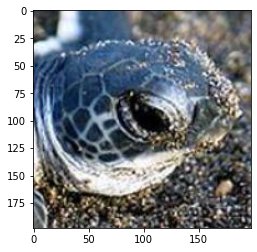

label:  1.0  --> FACE


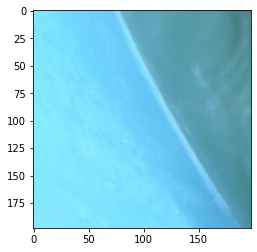

label:  0.0  --> NO FACE


In [6]:
def show_image(x, y, index):
    categ=''
    plt.imshow(x[index])
    plt.show()
    if y[index]==0 : categ='NO FACE'
    elif y[index]==1 : categ='FACE'
    else: 'ERROR'   
    print('label: ', y[index], " -->", categ)
    
show_image(images, labels, 0)
show_image(images, labels, 1999)

In [7]:
images[0].shape

(198, 198, 3)

### CNN Implementation

In [8]:
seed = 2056112
np.random.seed(seed)

# X,y
X = np.copy(images)
y = np.copy(labels)

permutation = np.random.permutation(len(y)) # permutation is a list of shuffled indexes

X = X[permutation]
y = y[permutation]

#training-test split
perc_training = 0.8
m_training = int(len(y)*0.8)
m_test = len(y) - int(len(y)*0.8)

X_train, X_test = X[:m_training], X[m_training:m_training+m_test]
y_train, y_test = y[:m_training], y[m_training:m_training+m_test]

In [9]:
np.shape(X_train)

(3198, 198, 198, 3)

Some stats about training and test datasets

In [10]:
labels_tr, freqs_tr = np.unique(y_train, return_counts=True)
print("Total Training data:", m_training)
print("Labels in training dataset: ", labels_tr)
print("Frequencies in training dataset: ", freqs_tr)

labels_tst, freqs_tst = np.unique(y_test, return_counts=True)
print("Total Test data:", m_test)
print("Labels in test set: ", labels_tst)
print("Frequencies in test set: ", freqs_tst)

Total Training data: 3198
Labels in training dataset:  [0. 1.]
Frequencies in training dataset:  [1578 1620]
Total Test data: 800
Labels in test set:  [0. 1.]
Frequencies in test set:  [421 379]


## CNN

In [11]:
def build_cnn():

    #filters: how many features/patterns we are going to recognize in the images
    #kernel: shape of the matrix used for each filter's convolution
    #pooling: shape of the matrix used to generalise the feature map created by the convolution (the smaller the shape the longer the computation time)
    
    cnn = models.Sequential([

        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        layers.Conv2D(filters=30, kernel_size=(3,3), activation='relu', input_shape=(198,198,3)),
        layers.MaxPooling2D((10,10)),
        #dense
        layers.Flatten(),
        layers.Dense(50, activation='relu'),
        layers.Dense(2, activation='softmax')
        
    ])
    
    # compile
    cnn.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    #summary
    #print(cnn.summary())
    return cnn

In [12]:
cnn = build_cnn()
cnn.layers

2022-07-07 13:15:45.129633: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-07 13:15:45.130100: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-07 13:15:45.130841: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [22]:
from IPython.display import display 

def get_w(cnn):
    layer_w = [lay.get_weights() for lay in cnn.layers]
    return layer_w
def set_w(cnn,weights):
    for lay,w in zip(cnn.layers, weights):
        lay.set_weights(w)
    return cnn

cnn = build_cnn()
weights = get_w(cnn)
cnn = set_w(cnn, weights)

fit = cnn.fit(X_train[0:50], y_train[0:50], epochs=1)

w2 = get_w(cnn)

2022-07-07 13:30:48.571839: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-07-07 13:30:48.594912: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2096050000 Hz


2/2 [==============================] - 5s 979ms/step - loss: 42.5087 - accuracy: 0.4658


In [23]:
weights

[[array([[[[ 2.59296447e-02, -1.07016906e-01,  4.28609550e-02,
             1.27130881e-01, -8.38358700e-03,  1.34838179e-01,
             4.54832911e-02,  8.26626867e-02, -4.76608202e-02,
            -9.83203948e-02, -6.05726764e-02, -1.10802665e-01,
             7.25201666e-02,  8.27021301e-02,  5.53071499e-03,
            -1.03556335e-01, -1.28181756e-01,  5.65523803e-02,
             2.10310966e-02,  2.56009400e-02, -9.90499556e-03,
            -1.58684552e-02,  9.65484232e-02, -9.70804244e-02,
            -5.73430955e-03,  8.44795555e-02,  1.29096195e-01,
            -1.11750595e-01,  4.94586080e-02,  9.45305079e-02],
           [ 1.41144648e-01,  1.24637783e-03, -1.18214674e-01,
            -1.18436262e-01, -9.34099182e-02,  5.87360561e-02,
            -7.22570643e-02, -3.31402272e-02,  5.31861186e-02,
             4.92346883e-02,  5.71814626e-02,  9.09161121e-02,
             2.74925679e-02, -4.38603163e-02, -2.31742337e-02,
            -1.11556455e-01, -7.31517971e-02,  7.08032

In [24]:
w2

[[array([[[[ 2.39350814e-02, -1.08888149e-01,  4.47459035e-02,
             1.29132152e-01, -6.42187521e-03,  1.32893831e-01,
             4.36325334e-02,  8.07178915e-02, -4.90592457e-02,
            -1.00289911e-01, -6.17028624e-02, -1.10802665e-01,
             7.21058995e-02,  8.08224902e-02,  7.44926184e-03,
            -1.05460562e-01, -1.30072132e-01,  5.85468113e-02,
             1.90298166e-02,  2.36966312e-02, -1.16752414e-02,
            -1.78032611e-02,  9.50235650e-02, -9.90196019e-02,
            -3.73414345e-03,  8.64387825e-02,  1.27198398e-01,
            -1.13667771e-01,  4.75576743e-02,  9.25871357e-02],
           [ 1.39150798e-01, -6.21296756e-04, -1.19985171e-01,
            -1.16436705e-01, -9.14718136e-02,  5.68286404e-02,
            -7.41097778e-02, -3.50997001e-02,  5.15401326e-02,
             4.72446270e-02,  5.69016412e-02,  9.12765563e-02,
             2.70235594e-02, -4.57339808e-02, -2.12745052e-02,
            -1.13477260e-01, -7.49885440e-02,  7.27942

In [24]:
wb[0]

<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 3, 30) dtype=float32, numpy=
array([[[[ 0.00884953, -0.0738189 ,  0.10354017, -0.0322653 ,
          -0.13854307,  0.0362031 ,  0.05142927,  0.02060474,
           0.12827444, -0.00582303, -0.1016131 , -0.08853022,
           0.05525626,  0.01998741, -0.11378665,  0.07373607,
          -0.03170993, -0.12436963,  0.10978462,  0.08251953,
          -0.1209408 ,  0.01977365,  0.09426659,  0.01133803,
           0.02100415, -0.05314347, -0.0098366 , -0.07914316,
           0.02332148, -0.08955535],
         [-0.03016913,  0.05022389, -0.03515087,  0.11209355,
          -0.08378041,  0.13931651,  0.03709409,  0.02011508,
           0.08268466,  0.03207526,  0.11390038,  0.10225673,
          -0.12110719, -0.12615107, -0.133738  ,  0.11939623,
           0.09978831,  0.08454075,  0.04822869, -0.12794903,
           0.03310264,  0.12083821,  0.00947598,  0.13825503,
          -0.09386658, -0.03680794,  0.04233043,  0.06262751,
          -0.0496987

In [25]:
wa[0]

<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 3, 30) dtype=float32, numpy=
array([[[[ 0.00884953, -0.0738189 ,  0.10354017, -0.0322653 ,
          -0.13854307,  0.0362031 ,  0.05142927,  0.02060474,
           0.12827444, -0.00582303, -0.1016131 , -0.08853022,
           0.05525626,  0.01998741, -0.11378665,  0.07373607,
          -0.03170993, -0.12436963,  0.10978462,  0.08251953,
          -0.1209408 ,  0.01977365,  0.09426659,  0.01133803,
           0.02100415, -0.05314347, -0.0098366 , -0.07914316,
           0.02332148, -0.08955535],
         [-0.03016913,  0.05022389, -0.03515087,  0.11209355,
          -0.08378041,  0.13931651,  0.03709409,  0.02011508,
           0.08268466,  0.03207526,  0.11390038,  0.10225673,
          -0.12110719, -0.12615107, -0.133738  ,  0.11939623,
           0.09978831,  0.08454075,  0.04822869, -0.12794903,
           0.03310264,  0.12083821,  0.00947598,  0.13825503,
          -0.09386658, -0.03680794,  0.04233043,  0.06262751,
          -0.0496987

In [26]:
waa[0]

<tf.Variable 'conv2d_4/kernel:0' shape=(3, 3, 3, 30) dtype=float32, numpy=
array([[[[ 0.00884953, -0.0738189 ,  0.10354017, -0.0322653 ,
          -0.13854307,  0.0362031 ,  0.05142927,  0.02060474,
           0.12827444, -0.00582303, -0.1016131 , -0.08853022,
           0.05525626,  0.01998741, -0.11378665,  0.07373607,
          -0.03170993, -0.12436963,  0.10978462,  0.08251953,
          -0.1209408 ,  0.01977365,  0.09426659,  0.01133803,
           0.02100415, -0.05314347, -0.0098366 , -0.07914316,
           0.02332148, -0.08955535],
         [-0.03016913,  0.05022389, -0.03515087,  0.11209355,
          -0.08378041,  0.13931651,  0.03709409,  0.02011508,
           0.08268466,  0.03207526,  0.11390038,  0.10225673,
          -0.12110719, -0.12615107, -0.133738  ,  0.11939623,
           0.09978831,  0.08454075,  0.04822869, -0.12794903,
           0.03310264,  0.12083821,  0.00947598,  0.13825503,
          -0.09386658, -0.03680794,  0.04233043,  0.06262751,
          -0.0496987

In [24]:
wbb = cnn.trainable_variables[0].assign(wb[0])
wbb

<tf.Variable 'UnreadVariable' shape=(3, 3, 3, 30) dtype=float32, numpy=
array([[[[-0.03314567, -0.10665788, -0.02689671,  0.02336119,
           0.06612492, -0.0932841 , -0.06768272,  0.09792554,
          -0.09502629,  0.07372053,  0.06000458,  0.01642736,
          -0.03745147,  0.05613904,  0.01999756,  0.07240124,
           0.13429958,  0.03484226, -0.06541359, -0.14150101,
           0.02650181,  0.06922603,  0.03951779, -0.12122155,
          -0.13339922,  0.11491933,  0.07310072, -0.05826539,
          -0.09516633,  0.09290251],
         [ 0.08480579, -0.1252641 , -0.06692718, -0.07088554,
          -0.04833296,  0.0544733 ,  0.0726487 ,  0.1254505 ,
           0.11828203, -0.07751816, -0.07616894,  0.03253176,
           0.14234823,  0.1313375 , -0.11454896, -0.01977597,
          -0.04655232, -0.0763744 ,  0.04825522,  0.11798567,
          -0.08352777, -0.03643443, -0.02423736, -0.05081708,
           0.03854652,  0.03625502, -0.06737556,  0.03947105,
          -0.14406765, 

In [32]:
print(len(wa),len(wa[0]),len(wa[0][0]),len(wa[0][0][0]),len(wa[0][0][0][0]))

8 3 3 3 30


In [18]:
print("time needed to compile the training set: ", time_compiling, " s")

time needed to compile the training set:  794.772502  s


In [40]:
loss, acc = cnn.evaluate(X_test, y_test)

25/25 [==============================] - 1s 30ms/step - loss: 6.5627 - accuracy: 0.4525


In [41]:
print(acc)

0.45249998569488525


let see the CNN at work in a prediction

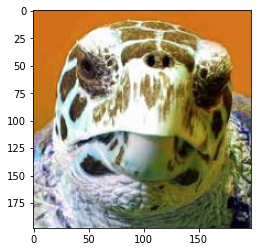

label:  1.0  --> FACE


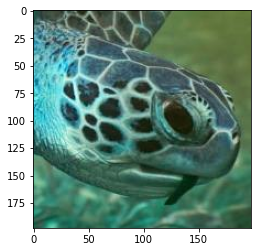

label:  1.0  --> FACE


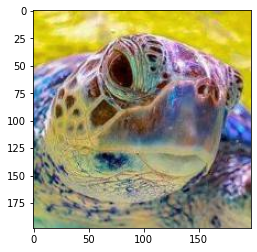

label:  1.0  --> FACE


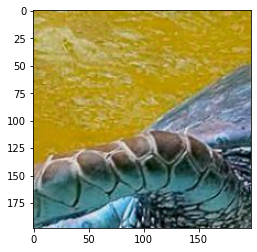

label:  0.0  --> NO FACE


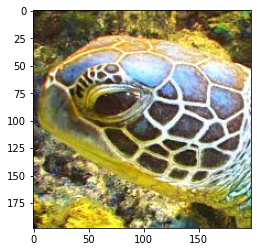

label:  1.0  --> FACE


In [20]:
some_indexes = [0,10,23,111,201]
for i in some_indexes:
    show_image(X_test, y_test, i)

### CNN Accuracy plot

In [23]:
def Show_history(fit):
    fig,AX=plt.subplots(1,2,figsize=(12,5.))
    ax=AX[0]
    ax.plot(fit.history['accuracy'],"b",label="train")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Accuracy")
    ax.legend()
    ax=AX[1]
    ax.plot(fit.history['loss'],"b",label="train")
    ax.set_xlabel('epoch')
    ax.set_ylabel("Loss")
    ax.set_ylim([0, 1.05*np.max(fit.history['loss'])])
    ax.legend()
    plt.show()

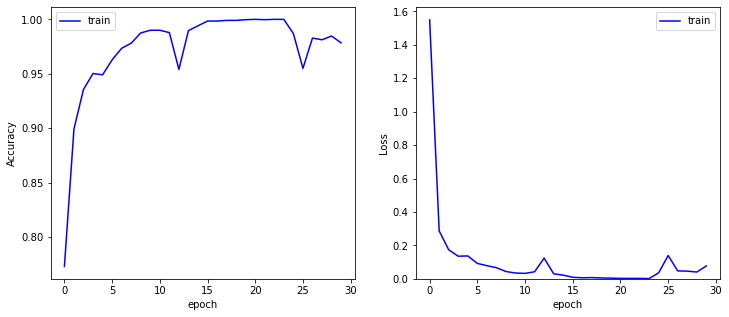

In [24]:
Show_history(fit)